In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from scipy.fft import fft, fftfreq, ifft
from scipy.interpolate import CubicSpline#, RectBivariateSpline, RegularGridInterpolator
#from scipy.optimize import minimize_scalar
#from scipy.integrate import simps
#from scipy.interpolate import interp1d
#from scipy.integrate import trapz
#from scipy.integrate import quadrature
#from scipy.integrate import quad
#from scipy.interpolate import interp2d
#import sympy as sp
#from mpmath import invertlaplace
#import mpmath as mp

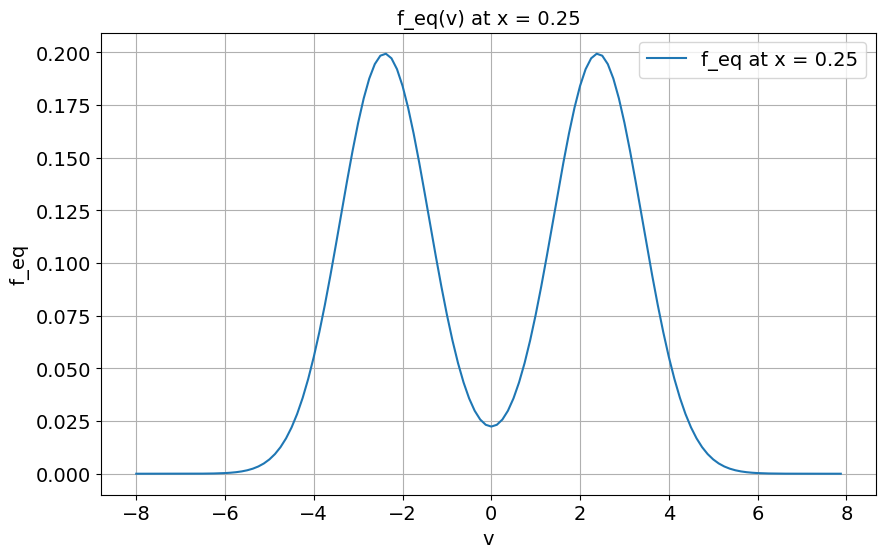

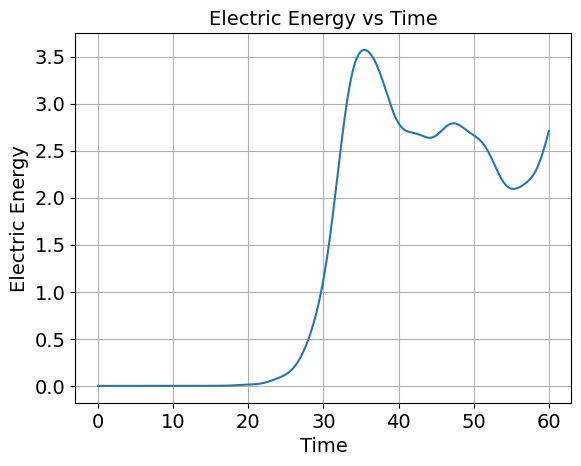

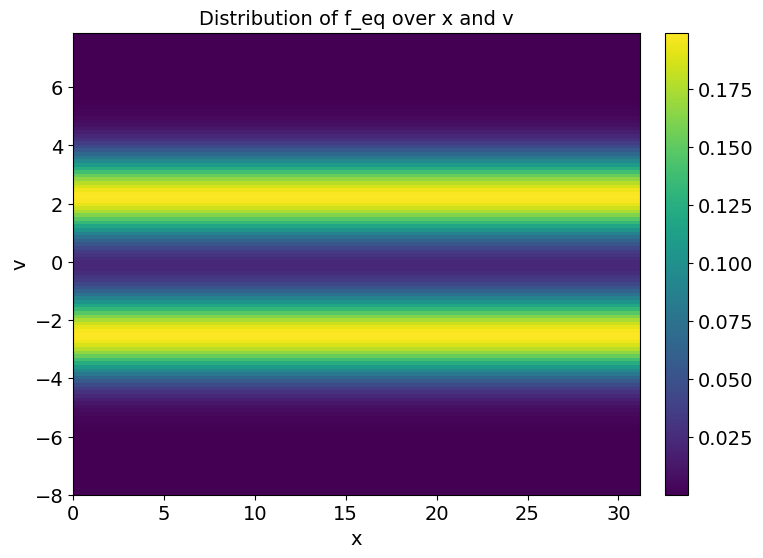

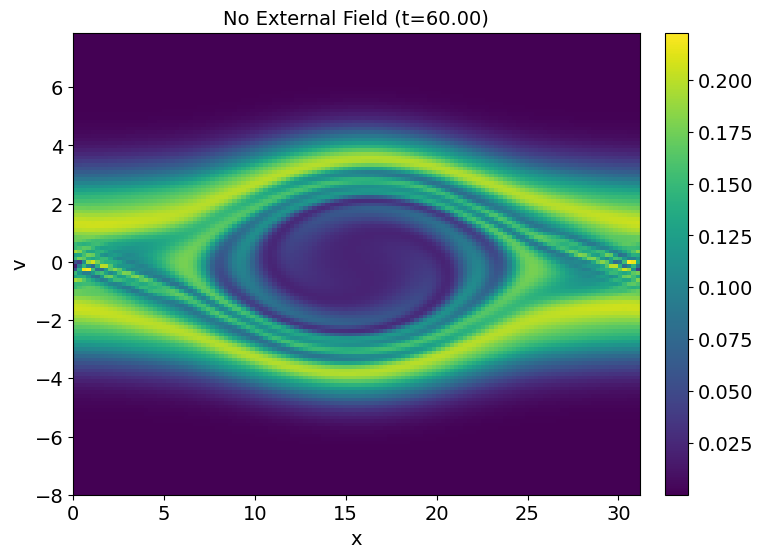

In [5]:
mpl.rcParams.update({'font.size': 14,  # General font size
                 'axes.labelsize': 14,  # Axis label size
                 'axes.titlesize': 14,  # Title size
                 'xtick.labelsize': 14,  # X-tick label size
                 'ytick.labelsize': 14,  # Y-tick label size
                 'legend.fontsize': 14})  # Legend font size


def make_mesh(L, LV, nx, nv):
    xs = np.linspace(0, L, nx, endpoint=False)
    dx = xs[1]-xs[0]

    vs = np.linspace(-LV, LV, nv, endpoint=False)
    dv = vs[1]-vs[0]

    V, X = np.meshgrid(vs, xs)
    return X, V, xs, vs, dx, dv

# def semilag_x(deltat, f):
#     for i, v in zip(range(len(vs)), vs):
#         f[:,i] = interp(xs - v*deltat, xs, f[:,i], period=L)

def semilag_x(dt, f, xs, vs, dx):

    Xs = np.concatenate([xs, [xs[-1]+dx]])

    for i, v in zip(range(len(vs)), vs):

        sp = CubicSpline(Xs, np.concatenate([f[:,i], [f[0,i]]]), bc_type='periodic')

        f[:,i] = sp(Xs[:-1] - v*dt)

# def semilag_v(deltat, f, E, s=None):

#     for i in range(len(xs)):
#         f[i,:] = interp(vs - E[i]*deltat, vs, f[i,:], period=2.0*LV)
#         f[i,:] += deltat*s[i] if s is not None else 0.0

def semilag_v(dt, f, E, xs, vs, dv, s=None):

    Vs = np.concatenate([vs, [vs[-1]+dv]])

    for i, v in zip(range(len(xs)), xs):

        sp = CubicSpline(Vs, np.concatenate([f[i,:], [f[i,0]]]), bc_type='periodic')

        f[i,:] = sp(Vs[:-1] - E[i]*dt)

def compute_rho(f, f_eq, dv):
    return dv*np.sum(f_eq, axis=1) - dv*np.sum(f, axis=1)

def compute_E_from_rho(rho, nx, L):
    rhohat = fft(rho)
    Ehat = 1j*np.zeros(len(rhohat))
    Ehat[1:] = -1.0/(1j* 2 * np.pi * fftfreq(nx, d=L/nx)[1:])*rhohat[1:]
    #Ehat[1:] = -1.0/(1j * fftfreq(len(rhohat), d=L/nx)[1:])*rhohat[1:]
    Ehat[0] = 0.0
    return np.real(ifft(Ehat))

def compute_E(f, f_eq, nx, L, dv):
    return compute_E_from_rho(compute_rho(f, f_eq, dv), nx, L)

def electric_energy(E, dx):
    return 0.5*np.sum(E**2)*dx

def time_step_forward(dt, f, H, L, nx, xs, vs, dx, dv):
    semilag_x(0.5*dt, f, xs, vs, dx)
    f_star = f.copy()
    E = compute_E(f, f_eq, nx, L, dv)
    E_total = E + H
    semilag_v(dt, f, E_total, xs, vs, dv)
    semilag_x(0.5*dt, f, xs, vs, dx)
    return f_star, E_total

def run_forward(H, f_iv, f_eq, L, nx, xs, vs, dx, dv, dt):
    f = f_iv.copy()
    t = 0.0
    ees = []
    fs = [f.copy()]
    E_stars = []
    f_stars = []
    Es = []

    for i in range(num_steps):
        current_H = H[:,i]

        E = compute_E(f.copy(), f_eq, nx, L, dv)
        Es.append(E.copy())

        ee = electric_energy(E, dx)
        ees.append(ee)

        f_star, E_total_star = time_step_forward(dt, f, current_H, L, nx, xs, vs, dx, dv)

        fs.append(f.copy())
        f_stars.append(f_star.copy)
        E_stars.append(E_total_star)

        t += dt

    return fs, ees, f_stars, E_stars, Es

# Problem setup
nx = 128
nv = 128
deltat  = 0.1
problem = 'ts'
t_final = 60  # Adjusted for demonstration purposes

# Setup for 'ts' problem
L = 10*np.pi
LV = 8.0
X, V, xs, vs, dx, dv = make_mesh(L, LV, nx, nv)
alpha = 0.5
mu1 = 2.4
mu2 = -2.4
f_eq = (alpha * np.exp(-0.5*(V-mu1)**2) + (1 - alpha) * np.exp(-0.5*(V-mu2)**2))/np.sqrt(2*np.pi)
epsilon = 0.001
k_0 = 0.2
f_iv = (1.0 + epsilon*np.cos(k_0*X)) * f_eq

num_steps = int(t_final/deltat)
t_values = np.linspace(0, t_final, num_steps)
dt = t_values[1] - t_values[0]

plt.figure(figsize=(10, 6))
plt.plot(vs, f_eq[1, :], label=f'f_eq at x = {xs[1]:.2f}')
plt.xlabel('v')
plt.ylabel('f_eq')
plt.title(f'f_eq(v) at x = {xs[1]:.2f}')
plt.legend()
plt.grid(True)
plt.show()

# Setting H to be zero
H = np.zeros((len(xs), num_steps))

# Run the forward simulation
fs, ees, f_stars, E_stars, Es = run_forward(H, f_iv, f_eq, L, nx, xs, vs, dx, dv, dt)

# Assuming ees (electric energies) and t_values (time values) are already computed from your simulation

# Plotting the electric energy with respect to time
plt.plot(t_values, ees)
plt.xlabel('Time')
plt.ylabel('Electric Energy')
plt.title('Electric Energy vs Time')
plt.grid(True)
plt.show()

# Create a figure with a single plot for f_eq
fig, ax = plt.subplots(figsize=(8, 6))

# Function to plot the distribution of f_eq over x and v
def plot_feq_distribution(ax, f_eq, title):
    im = ax.imshow(f_eq.transpose(), extent=[xs[0], xs[-1], vs[0], vs[-1]], aspect='auto', cmap='viridis')  # 'auto' aspect ratio
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('v')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Adjusted colorbar size

# Plot the distribution of f_eq
plot_feq_distribution(ax, f_eq, 'Distribution of f_eq over x and v')

# Display the plot
plt.show()

# Create a figure with a single plot
fig, ax = plt.subplots(figsize=(8, 6))  # Adjusted figsize for a single graph

# Function to plot the distribution
def plot_distribution(ax, data, index, title, time):
    im = ax.imshow(data[index].transpose(), extent=[xs[0], xs[-1], vs[0], vs[-1]], aspect='auto')  # 'auto' aspect ratio
    ax.set_title(f'{title} (t={time:.2f})')
    ax.set_xlabel('x')
    ax.set_ylabel('v')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Adjusted colorbar size


# Plot the distribution for the desired case
plot_distribution(ax, fs, num_steps - 1, 'No External Field', t_final)

# Display the plot
plt.show()






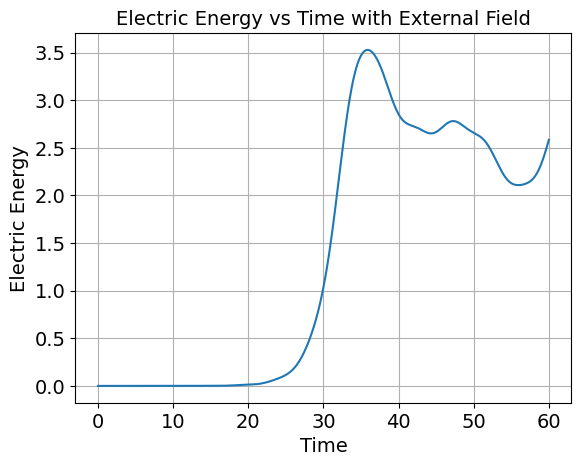

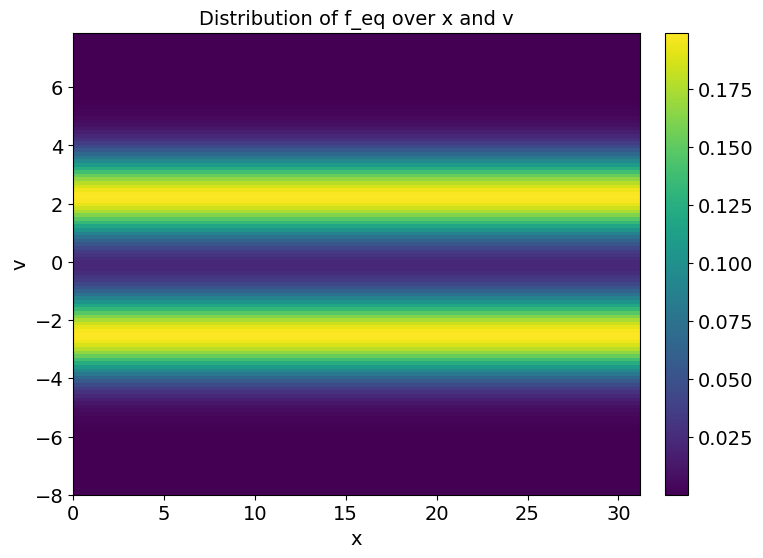

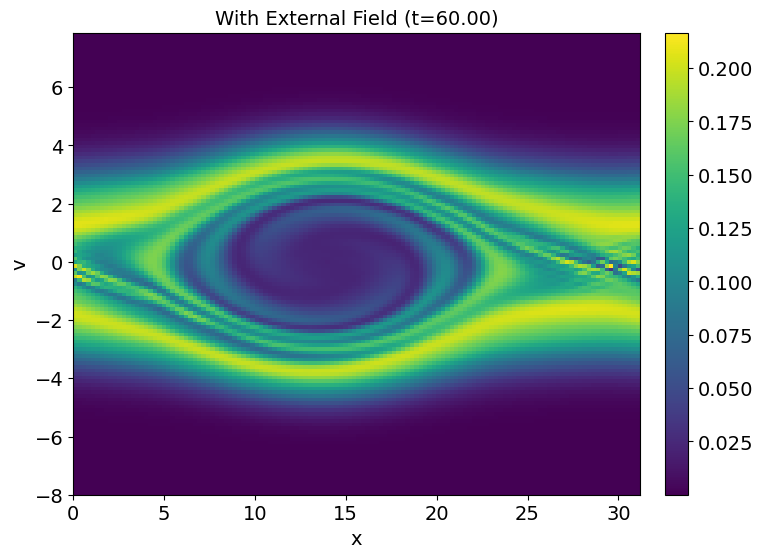

In [4]:
# External field parameters (coefficients for the cosine terms)
a_k = [0.00000591, -0.00003512, 0.00134810, -0.01075167, 0.01016702]

# Function to compute the external field H
def compute_external_field(xs, num_steps, a_k):
    H = np.zeros((len(xs), num_steps))  # Initialize H as zeros with dimensions (space, time)
    for k in range(1, 6):  # Iterate over k from 1 to 5
        H += a_k[k-1] * np.cos(0.5 * k * xs[:, None])  # Compute H for each k and sum
    return H

# Setting H using the given a_k values
H = compute_external_field(xs, num_steps, a_k)

# Run the forward simulation with the external field
fs, ees, f_stars, E_stars, Es = run_forward(H)

# Plotting the electric energy with respect to time
plt.plot(t_values, ees)
plt.xlabel('Time')
plt.ylabel('Electric Energy')
plt.title('Electric Energy vs Time with External Field')
plt.grid(True)
plt.show()

# Create a figure with a single plot for f_eq
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the distribution of f_eq over x and v
plot_feq_distribution(ax, f_eq, 'Distribution of f_eq over x and v')

# Display the plot
plt.show()

# Create a figure with a single plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the distribution for the final step with the external field
plot_distribution(ax, fs, num_steps - 1, 'With External Field', t_final)

# Display the plot
plt.show()


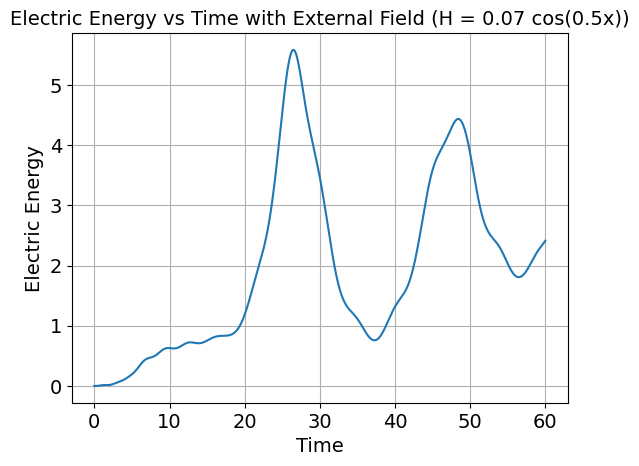

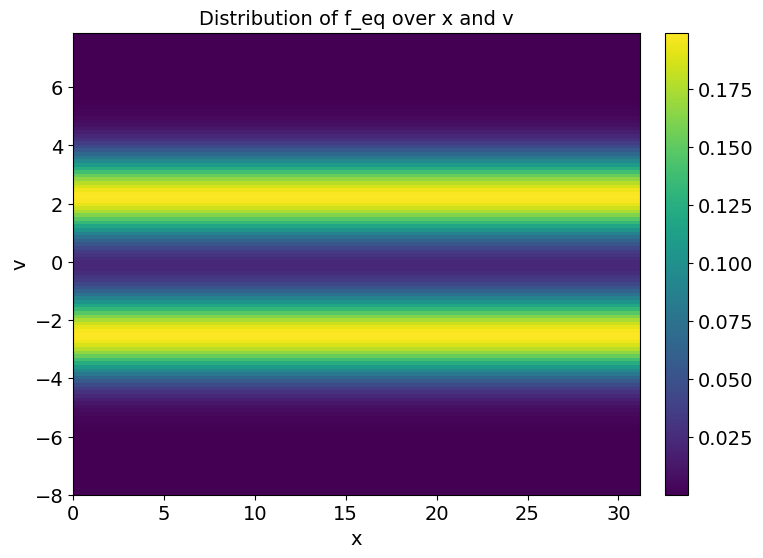

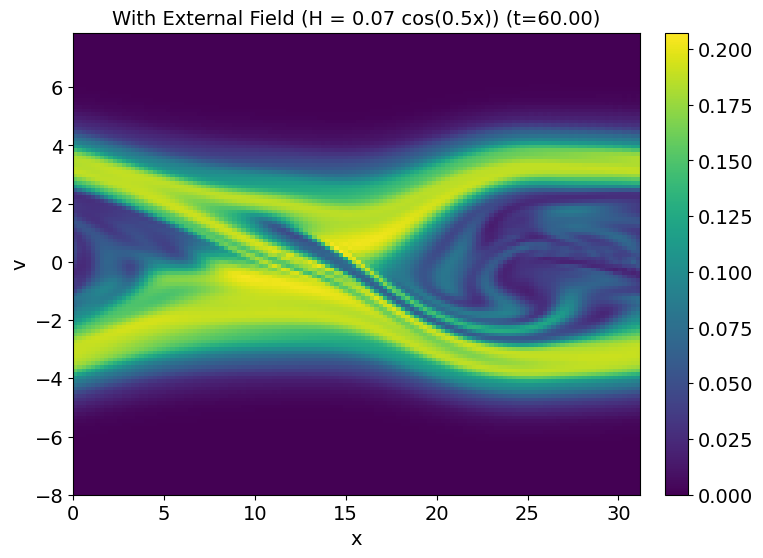

In [5]:
# External field parameter (0.07 cos(0.5 * x))
def compute_external_field(xs, num_steps):
    H_space = -0.15 * np.cos(0.5 * xs)  # Single cosine term for space
    H = np.tile(H_space[:, None], (1, num_steps))  # Repeat H_space across all time steps
    return H

# Setting H using the new formula
H = compute_external_field(xs, num_steps)

# Run the forward simulation with the updated external field
fs, ees, f_stars, E_stars, Es = run_forward(H)

# Plotting the electric energy with respect to time
plt.plot(t_values, ees)
plt.xlabel('Time')
plt.ylabel('Electric Energy')
plt.title('Electric Energy vs Time with External Field (H = 0.07 cos(0.5x))')
plt.grid(True)
plt.show()

# Create a figure with a single plot for f_eq
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the distribution of f_eq over x and v
plot_feq_distribution(ax, f_eq, 'Distribution of f_eq over x and v')

# Display the plot
plt.show()

# Create a figure with a single plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the distribution for the final step with the external field
plot_distribution(ax, fs, num_steps - 1, 'With External Field (H = 0.07 cos(0.5x))', t_final)

# Display the plot
plt.show()


Running simulation for a1 = -0.160


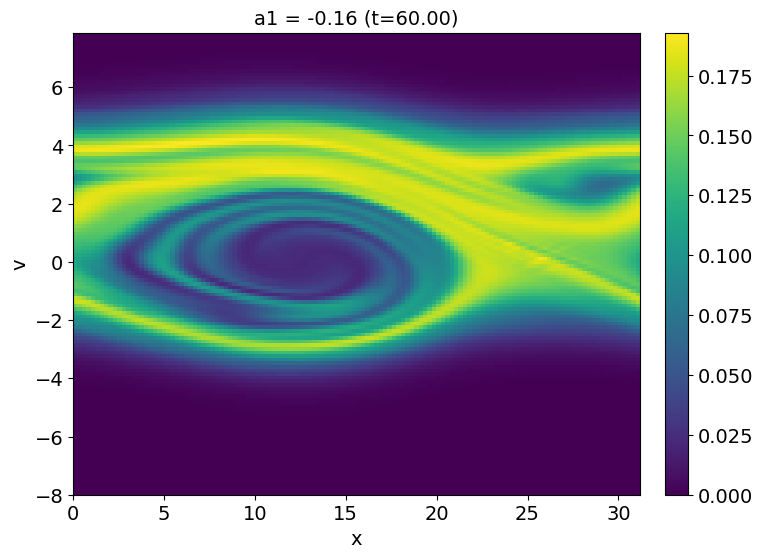

Running simulation for a1 = -0.150


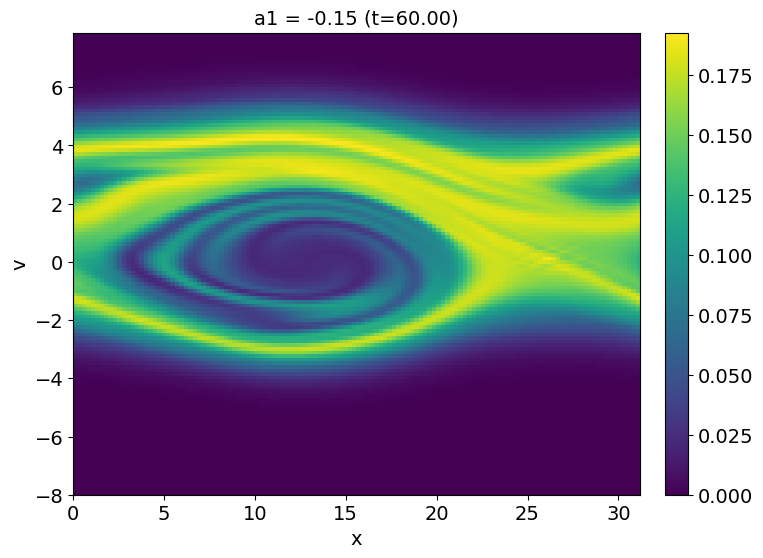

Running simulation for a1 = -0.140


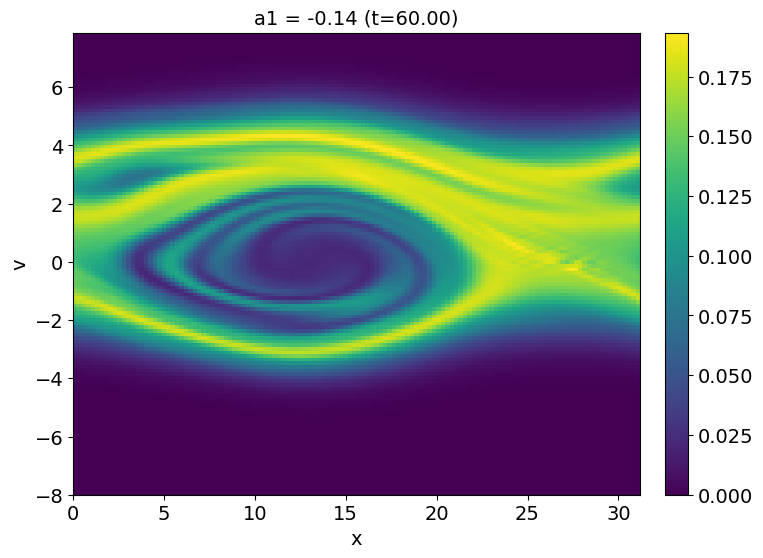

Running simulation for a1 = -0.130


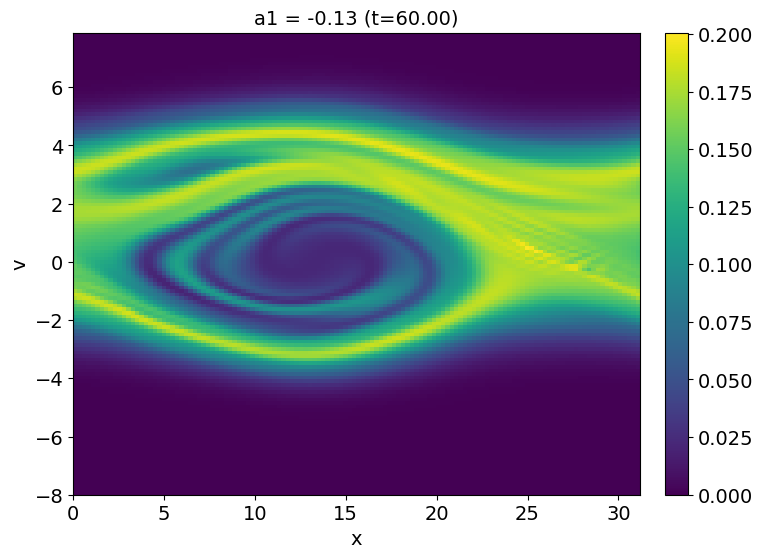

Running simulation for a1 = -0.120


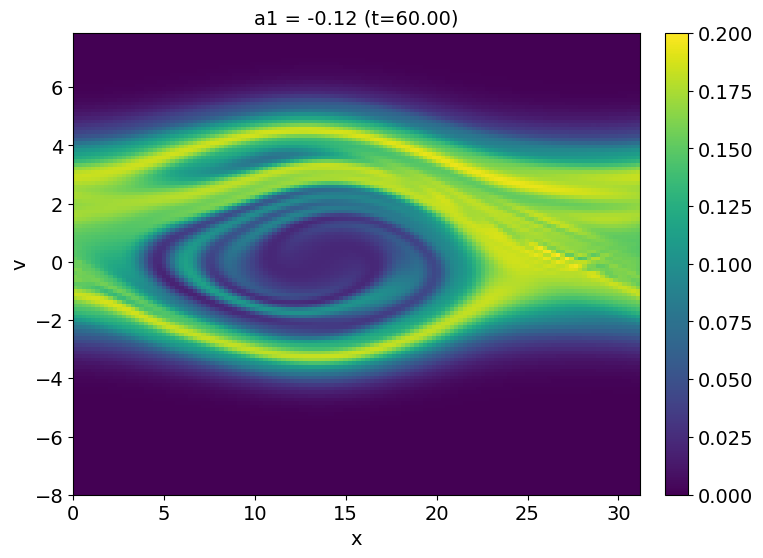

Running simulation for a1 = -0.110


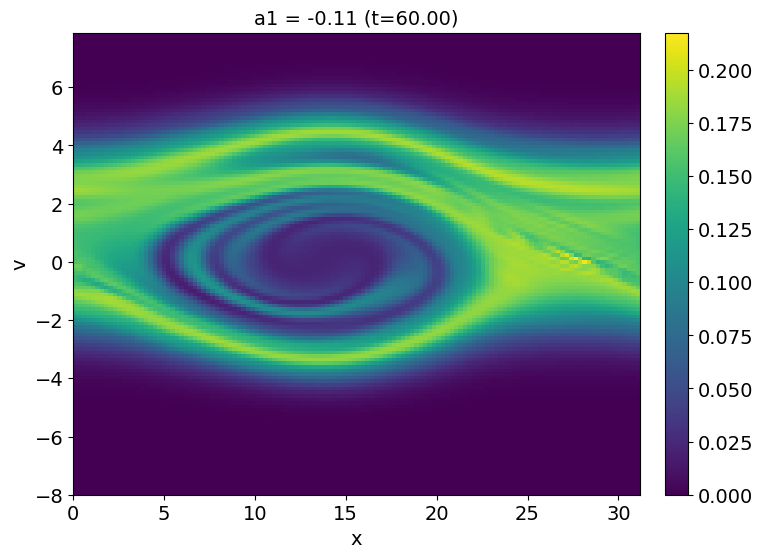

Running simulation for a1 = -0.100


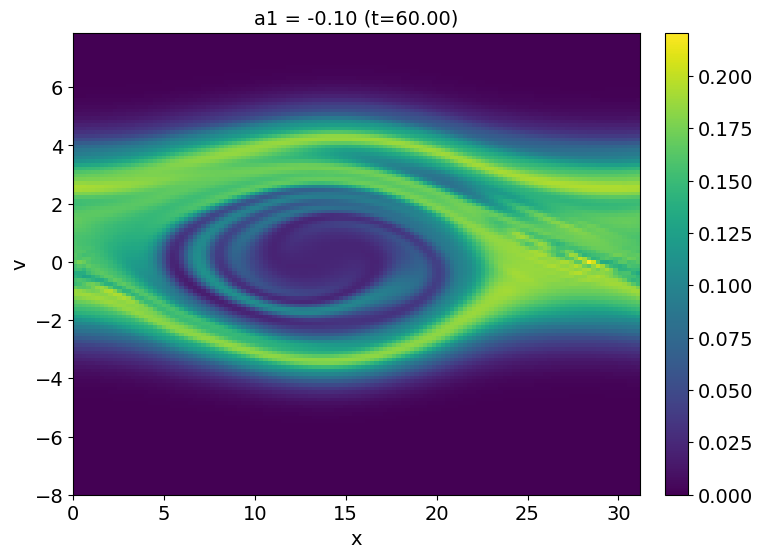

Running simulation for a1 = -0.090


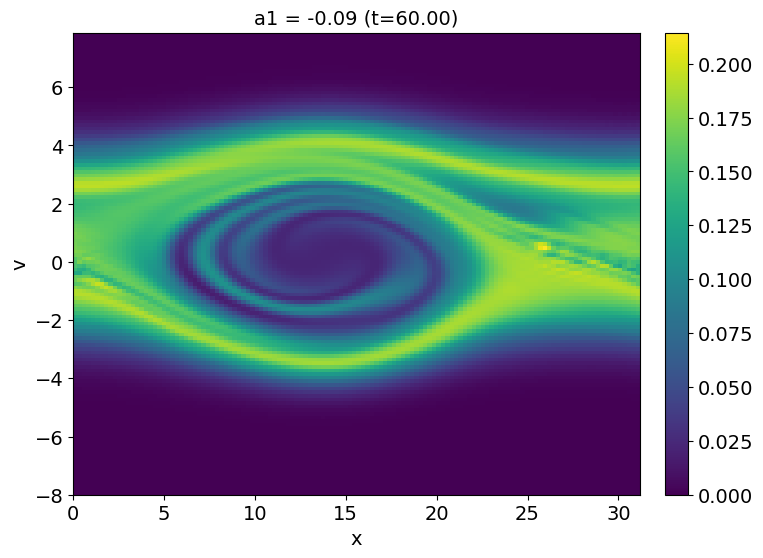

Running simulation for a1 = -0.080


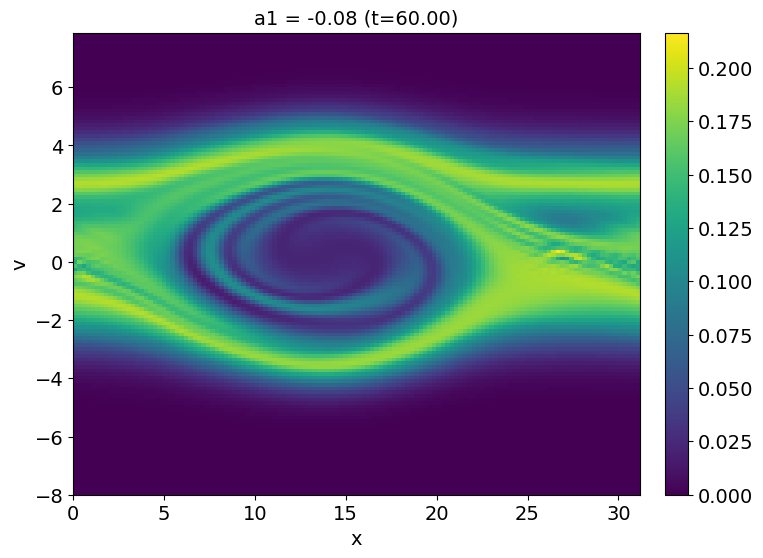

Running simulation for a1 = -0.070


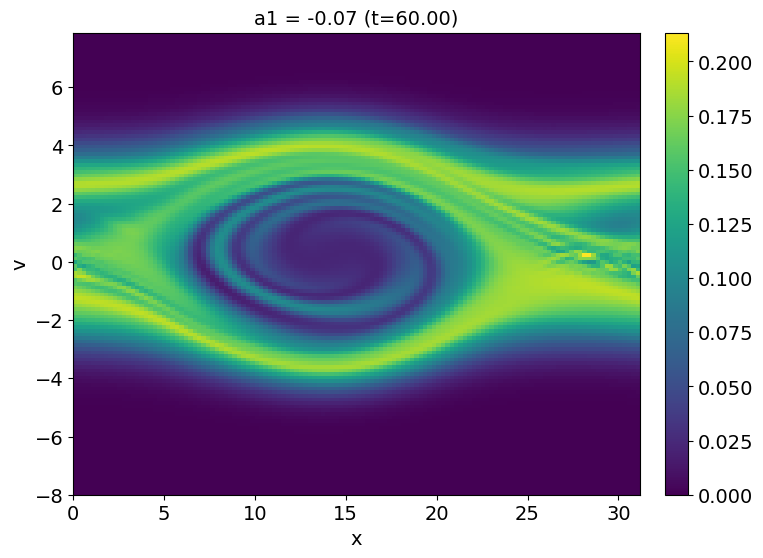

Running simulation for a1 = -0.060


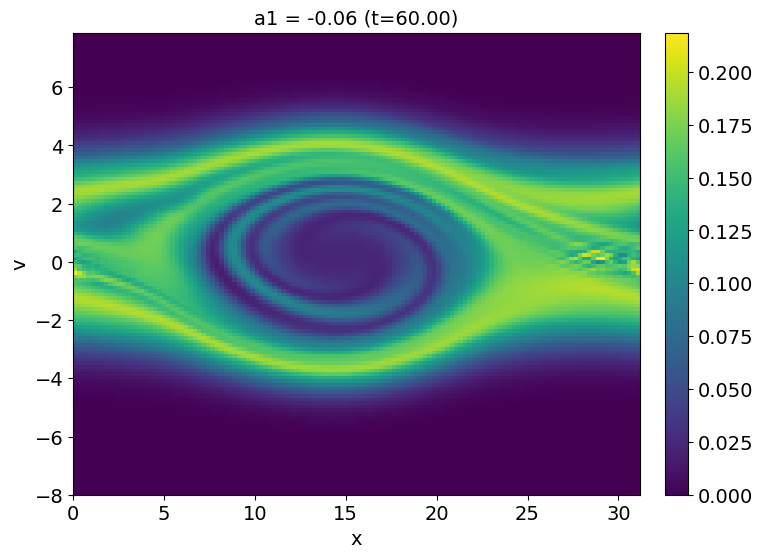

Running simulation for a1 = -0.050


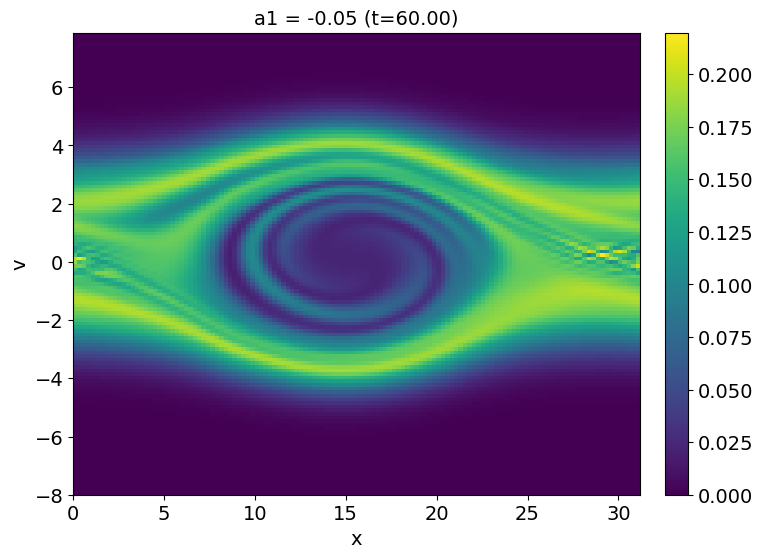

Running simulation for a1 = -0.040


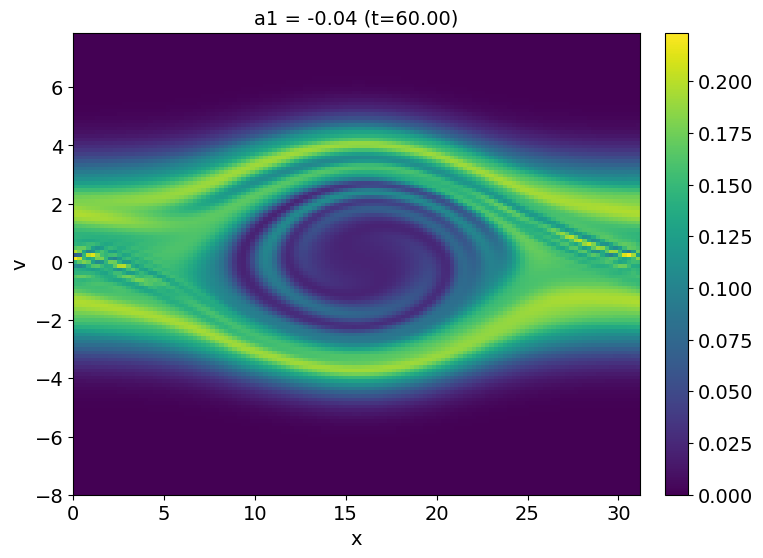

Running simulation for a1 = -0.030


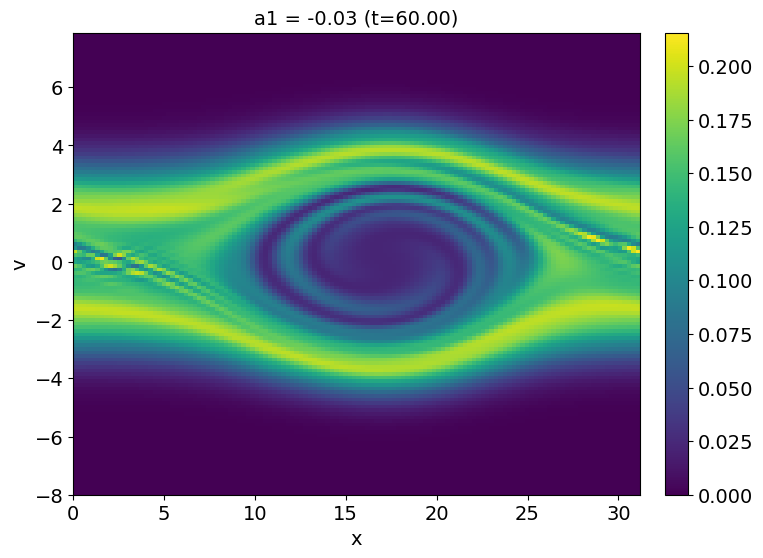

Running simulation for a1 = -0.020


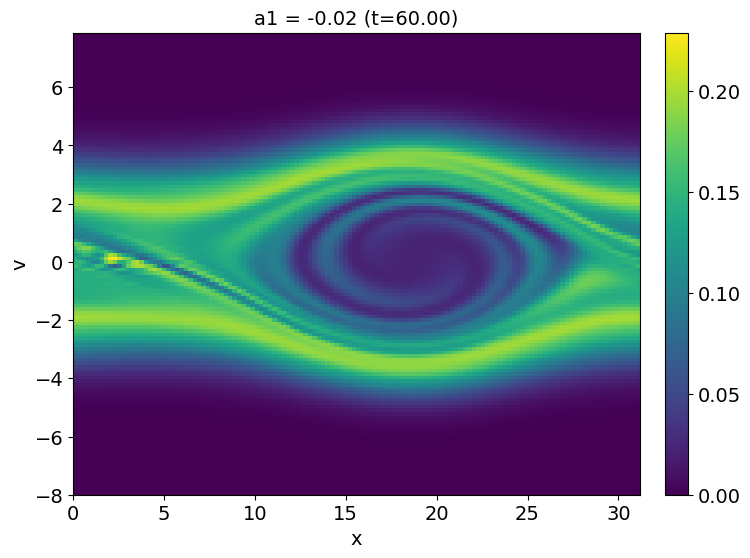

Running simulation for a1 = -0.010


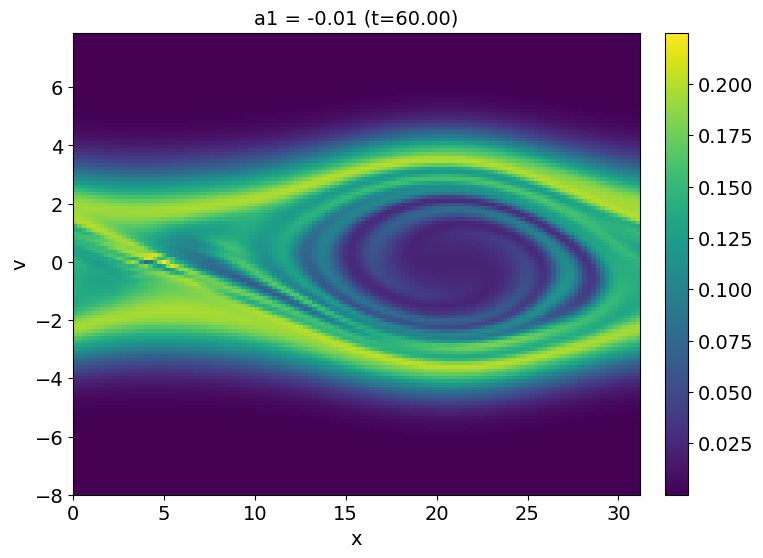

Running simulation for a1 = 0.000


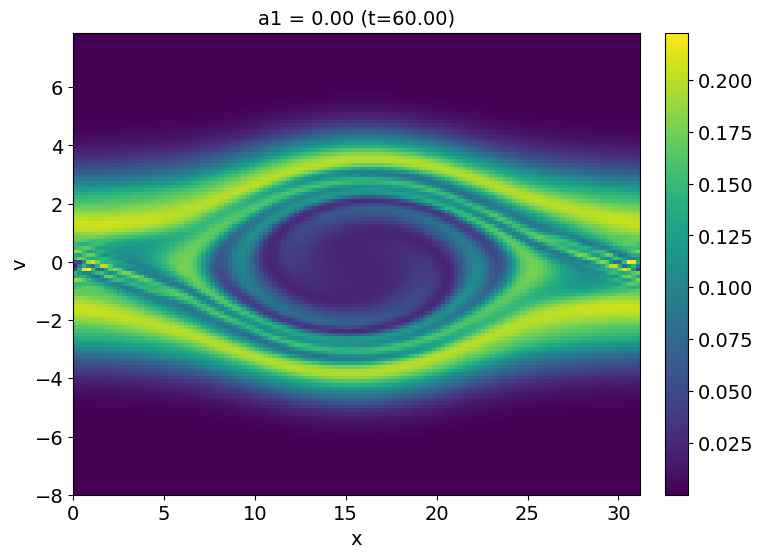

Running simulation for a1 = 0.010


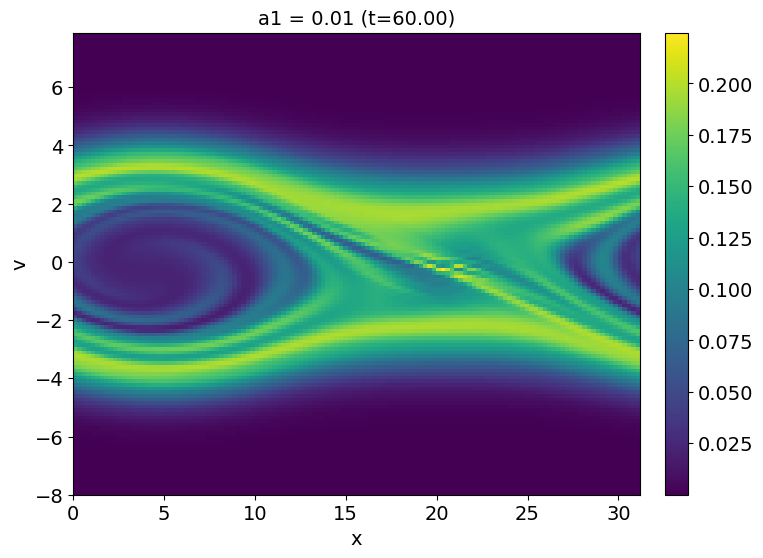

Running simulation for a1 = 0.020


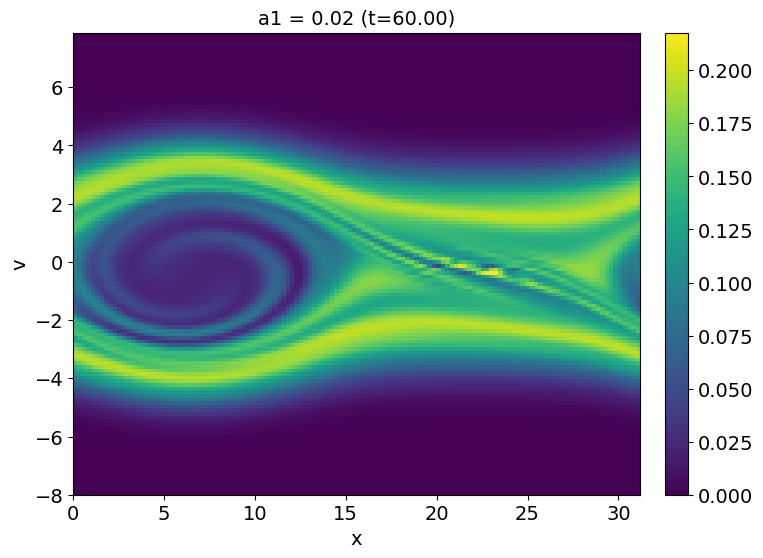

Running simulation for a1 = 0.030


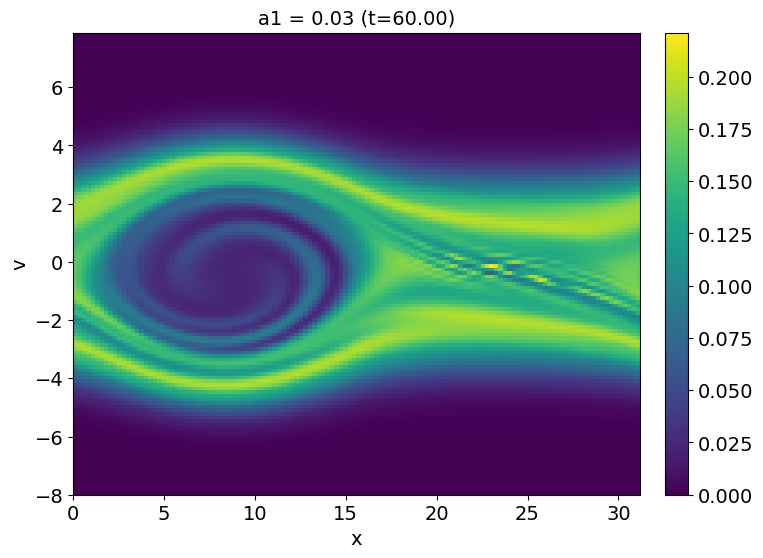

Running simulation for a1 = 0.040


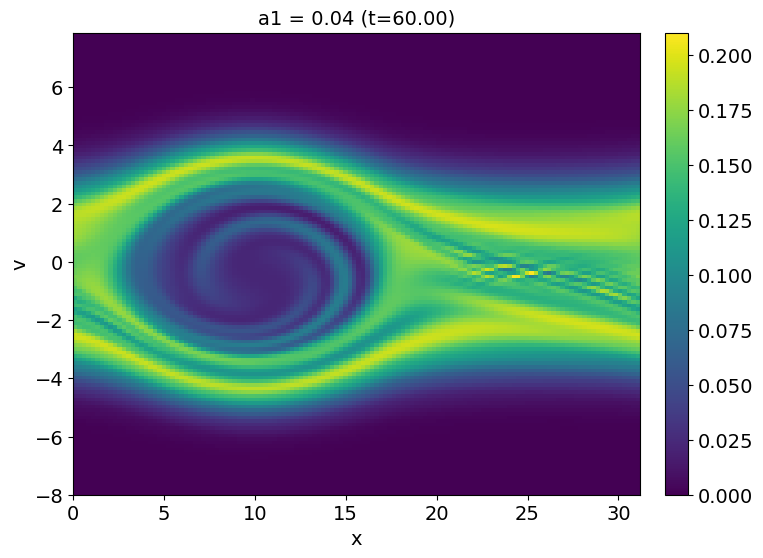

Running simulation for a1 = 0.050


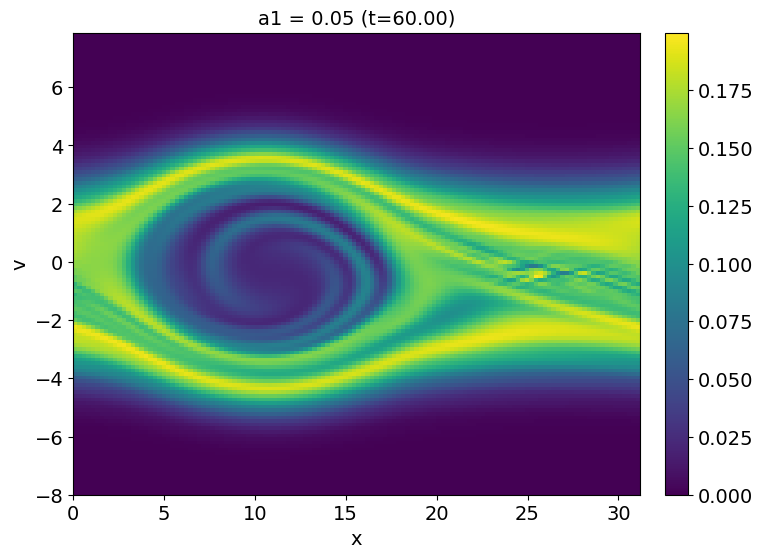

Running simulation for a1 = 0.060


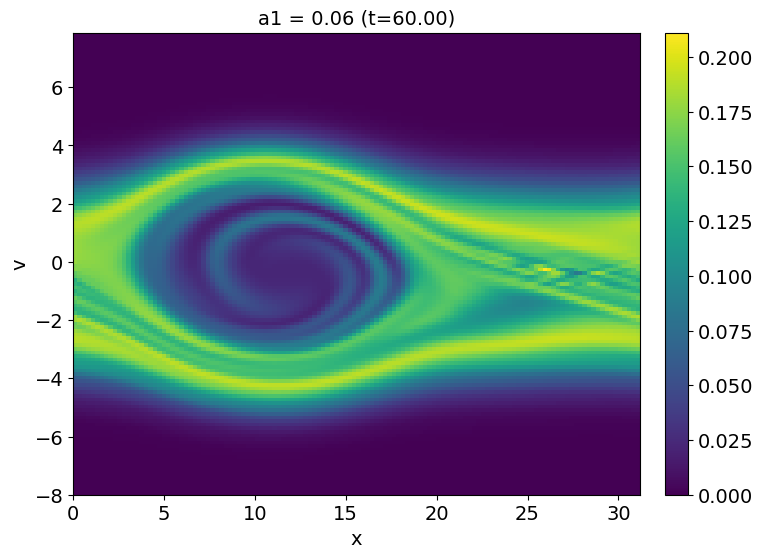

Running simulation for a1 = 0.070


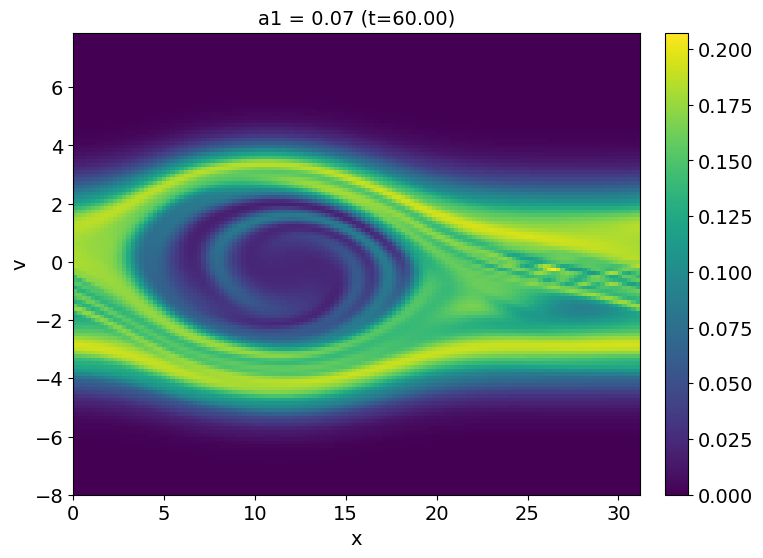

Running simulation for a1 = 0.080


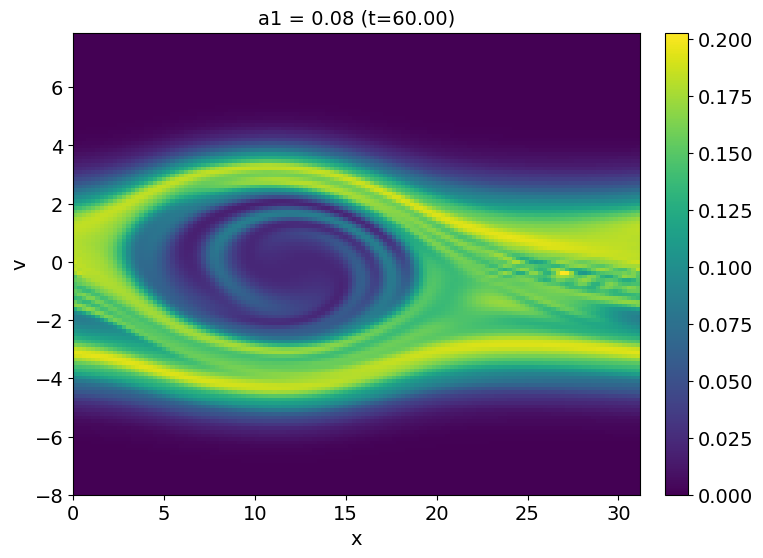

Running simulation for a1 = 0.090


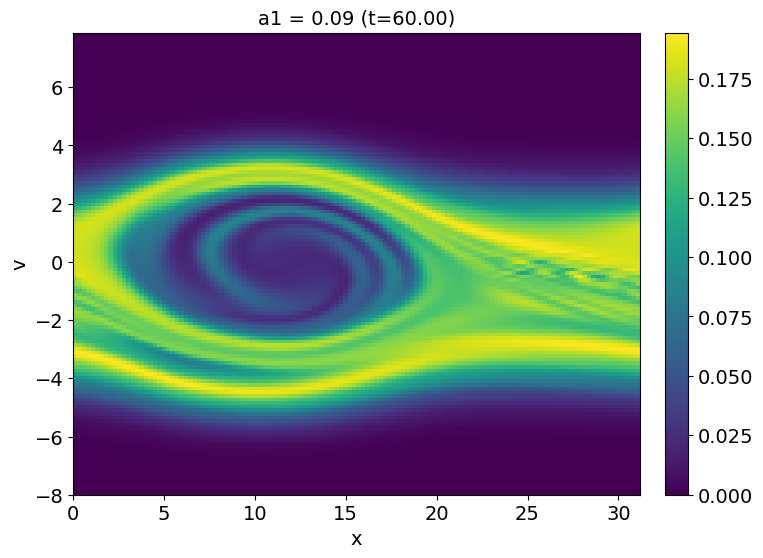

Running simulation for a1 = 0.100


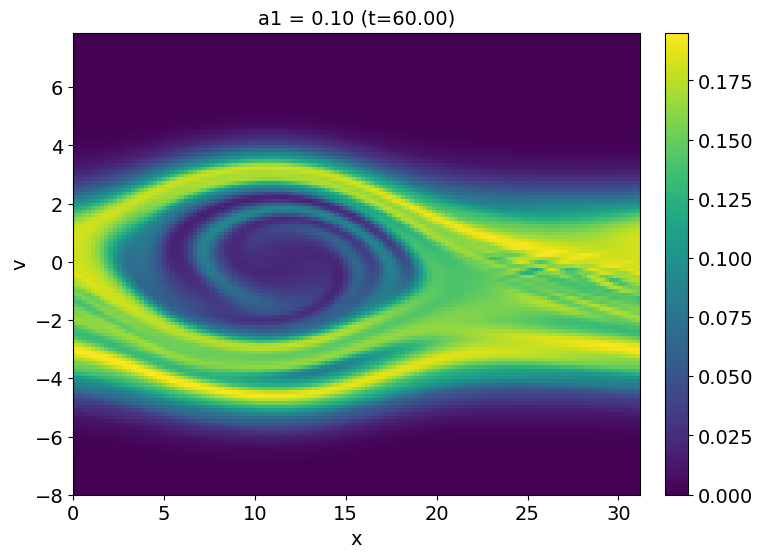

Running simulation for a1 = 0.110


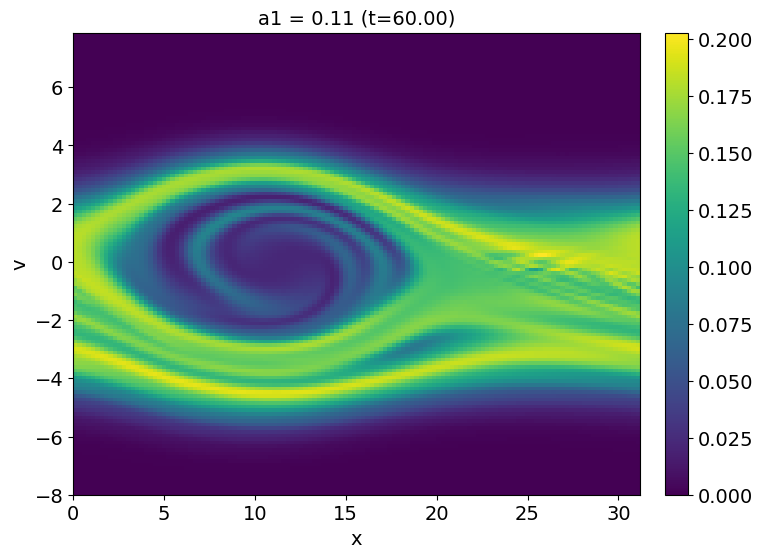

Running simulation for a1 = 0.120


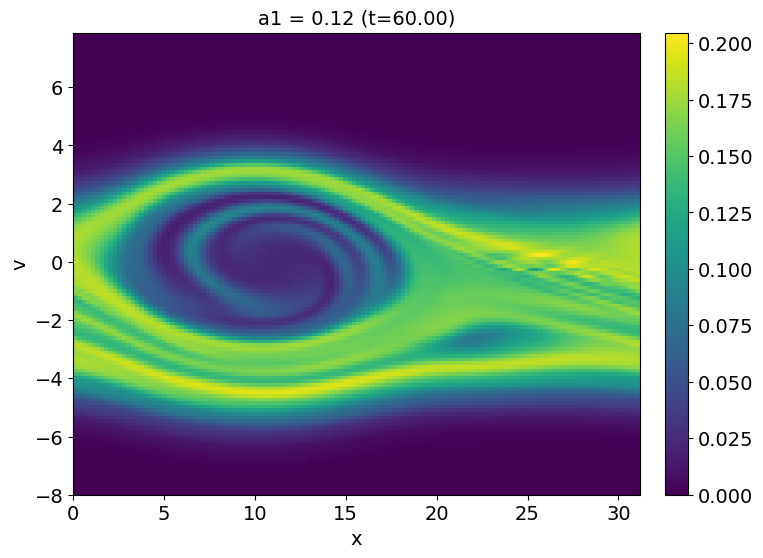

Running simulation for a1 = 0.130


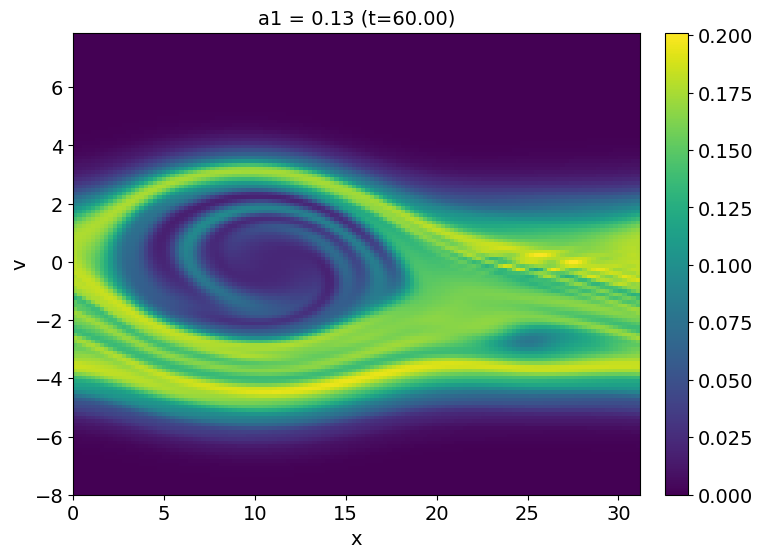

Running simulation for a1 = 0.140


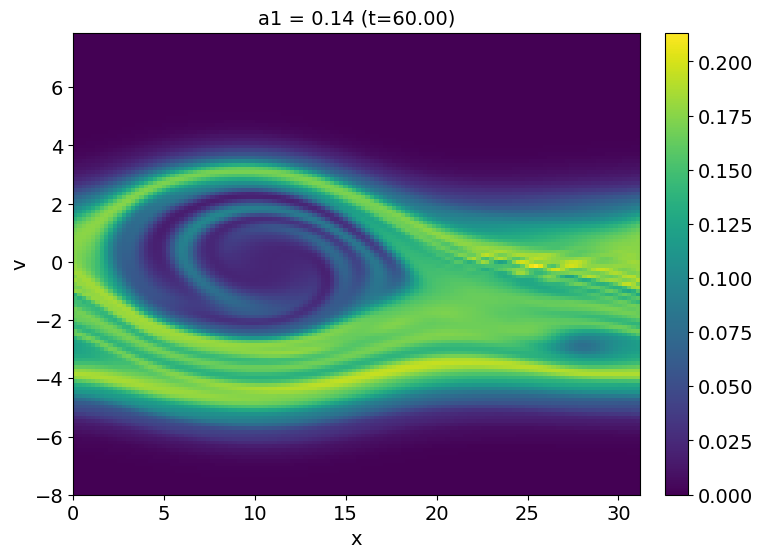

Running simulation for a1 = 0.150


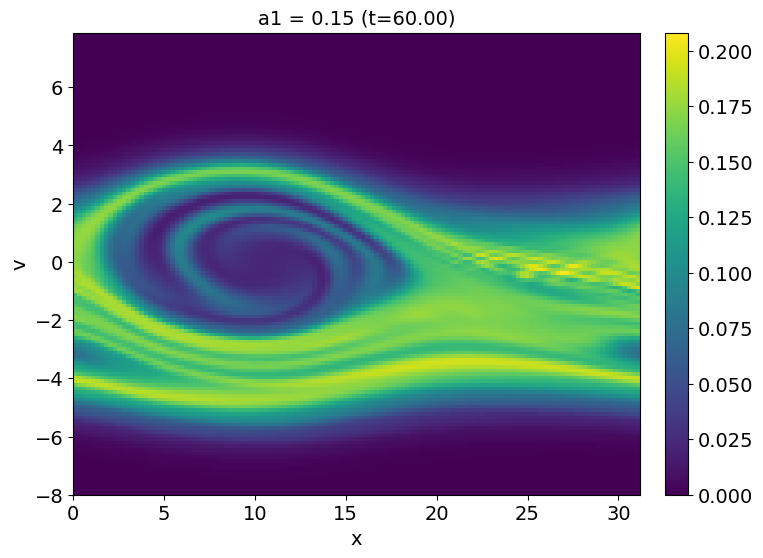

Running simulation for a1 = 0.160


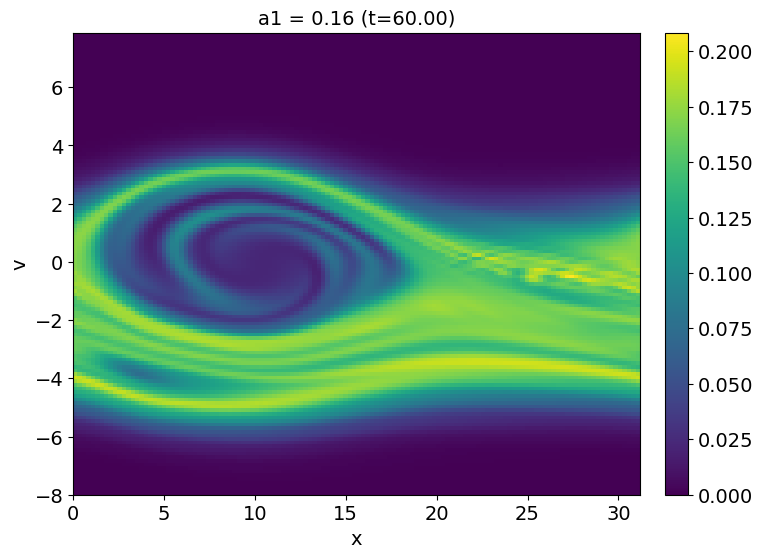

In [6]:
# Function to compute the external field H for a given a1
def compute_external_field_1d(xs, num_steps, a1):
    H_space = a1 * np.cos( 0.25 * xs)  # External field for given a1
    H = np.tile(H_space[:, None], (1, num_steps))  # Repeat H_space across all time steps
    return H

# 1D landscape search for a1 from -0.15 to 0.15 with step 0.01
a1_vals = np.arange(-0.16, 0.17, 0.01)

# Loop over all values of a1, compute H, run simulation, and plot the final distribution
for idx, a1 in enumerate(a1_vals):
    print(f"Running simulation for a1 = {a1:.3f}")

    # Compute the external field for the current a1
    H = compute_external_field_1d(xs, num_steps, a1)

    # Run the forward simulation with the current external field
    fs, ees, f_stars, E_stars, Es = run_forward(H)

    # Create a new figure for each plot
    fig, ax = plt.subplots(figsize=(8, 6))  # Adjusted figsize for a single graph

    # Plot the distribution for the final step with the current a1
    plot_distribution(ax, fs, num_steps - 1, f'a1 = {a1:.2f}', t_final)

    # Show the plot immediately after each iteration
    plt.show()

    # Optionally pause between iterations to view the plots more clearly
    plt.pause(1)  # Pauses for 1 second before showing the next plot (you can adjust this value)
